# Quantum circuit model for Blackhole evaporation

This time we consider a causal mechanism for blackhole evaporation, following https://arxiv.org/pdf/2104.14901.pdf

We start with four qubits, the first one being a matter state $\left | m \right\rangle$ initialized in an arbitrary state $\left | m \right\rangle = \mu \left | 0 \right\rangle + \left | 1 \right\rangle$. This state represents matter falling through the event horizon:

$$
\left | m \right\rangle = \alpha \left | 0 \right\rangle + \beta \left | 1 \right\rangle 
$$

This matter state is then coupled to another matter/radiation state $\left | g \right\rangle$ before it falls pass the event horizon, using a CNOT gate:

$$ 
\alpha \left | 0 \right\rangle_m \left | 0 \right\rangle_g + \beta \left | 1 \right\rangle_m \left | 1 \right\rangle_g
$$

When this happens, a Hawking pair is created near the horizon, with one qubit $\left | r_1 \right\rangle$ falling inside the bh and the other one $\left | r_2 \right\rangle$ escaping. The Hawking process is represented by the action of a arbitrary unitary transformation $U_H$ on $\left | r_1 \right\rangle$,

$$ 
U_H \left | r_1 \right\rangle = \lambda \left | 0 \right\rangle + \kappa \left |1 \right\rangle
$$

followed by a CNOT gate to entangle it with $\left | r_2 \right\rangle$ so that at the end, the state representing the Hawking pair is given by 

$$ 
\lambda \left | 0 \right\rangle_{r_1} \left | 0 \right\rangle_{r_2} + \kappa  \left | 1 \right\rangle_{r_1} \left | 1 \right\rangle_{r_2} 
$$

After the pair is created, the two qubits states $\left | m \right\rangle$ and $\left | r_1 \right\rangle$   inside the blackhole swap states, and the other two qubit states, $\left | g \right\rangle$ and $\left | r_2 \right\rangle$, which are outside the blackhole, also swap states. 

Finally, there are a couple more physical processes represented by CNOT acting on target qubits inside the blackole, so that this information transfer is from the outside to the inside, respecting causality. 
Therefore, the whole process never violates causality, in the form of information going out through the horizon.

Thanks to the entanglment among the qubits, however, the initial matter state $\left | m \right\rangle$ is completely transfered to the final outgoing hawking radiation qubit $\left | r_2 \right\rangle$ :
$$
\left | r_2  \right\rangle  = \alpha \left | 0 \right\rangle + \beta \left | 1 \right\rangle
$$

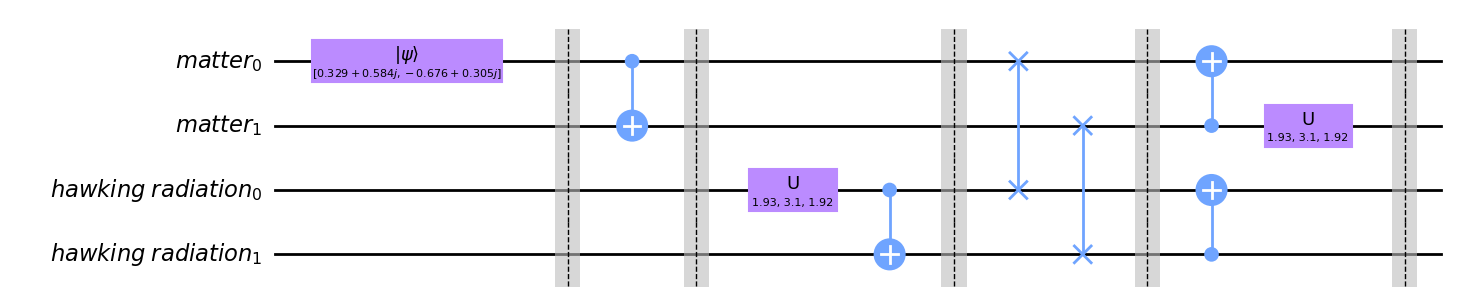

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import DensityMatrix, partial_trace, random_statevector, Statevector
import numpy as np
import random




M = QuantumRegister(2,name="matter")
R = QuantumRegister(2,name="hawking radiation")

hwqc = QuantumCircuit(M,R)

#initial state of infalling matter
initial_state = hwqc.initialize(random_statevector(2).data, M[0])
d0 = DensityMatrix(hwqc)
hwqc.barrier()

#entanglement with the other matter/radiation state 
hwqc.cx(M[0],M[1])
d1 = DensityMatrix(hwqc)
hwqc.barrier()

#hawking radiation created R0 is inside horizon and R1 is outside horizon
#hawking process is simulated by unitary gate with random rotation angles
a=2*np.pi*random.random()
b=2*np.pi*random.random()
c=2*np.pi*random.random()
hwqc.u(a,b,c,R[0])
hwqc.cx(R[0],R[1])
hwqc.barrier()
d2 = DensityMatrix(hwqc)


#swap operations between modes inside horizon, and between modes outside horizon
hwqc.swap(M[0],R[0])
hwqc.swap(M[1],R[1])
hwqc.barrier()


#physical process 1
hwqc.cx(M[1],M[0])
d3 = DensityMatrix(hwqc)

#physical process 2
hwqc.cx(R[1],R[0])
hwqc.u(a,b,c,M[1]).inverse()
hwqc.barrier()
d4 = DensityMatrix(hwqc)



#trace over inner modes


p0 = np.array(partial_trace(d0,[0,3]))
p1 = np.array(partial_trace(d1,[0,3]))
p2 = np.array(partial_trace(d2,[0,3]))
p3 = np.array(partial_trace(d3,[0,3]))
p4 = np.array(partial_trace(d4,[0,3]))

hwqc.draw(output="mpl")

In the end, all the information in the state "matter 0" is transferred out of the BH through the outgoing "hawking radiation 1". 
To see this, we compare both states:

In [2]:
matter0 = partial_trace(d0,[1,2,3])
hw1 = partial_trace(d4,[0,1,2])
hw1 == matter0

True

Let us now examine the Page profile of the process represented by our quantum circuit.  At each step, we have saved the density matrix of the quantum system, and in the end, we have traced out the modes inside the horizon, corresponding to "matter 0" and "hawking radiation 0". 
Next, we calculate the entanglement entropy for each step, and plot the approximate Page curve.

In [3]:
#von Neumann entropy
def neumann_entropy(array):
    #below calculate the von Neumann entropy using the expression $\sum \lambda_k ln \lamda_k
    #and exclude the \lambda_k =0 eigenvalues
    eigen = np.linalg.eigvalsh(array)
    entropy = 0
    for Lambda in eigen:
        if Lambda>=0.000001:
            entropy = entropy - Lambda * np.log2(Lambda)
    return entropy

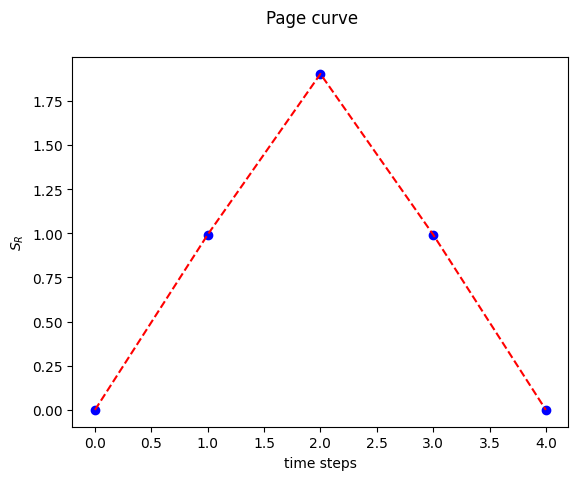

In [4]:
entropies = [neumann_entropy(p0),neumann_entropy(p1),neumann_entropy(p2),neumann_entropy(p3),neumann_entropy(p4)]
import matplotlib.pyplot as plt

plt.plot(entropies,"bo",entropies,"r--")
plt.ylabel('$S_R$')
plt.xlabel("time steps")
plt.suptitle('Page curve')
plt.show()

Let us now try to generalize the construction for $2^n$-qubit incoming matter distribution represented by a tensor product of arbitrary two-qubit states.

In [5]:
def bh_evaporation(n):
    M = QuantumRegister(2**n,name="matter")
    R = QuantumRegister(2**n,name="hawking radiation")
    genhwqc = QuantumCircuit(M,R)
    #initial state of infalling matter
    for i in range(2**(n-1)):
        initial_state = genhwqc.initialize(random_statevector(2).data, M[i])
    d0 = Statevector(genhwqc)
    genhwqc.barrier()

    densities = [d0]
    #entanglement with the other matter/radiation state 
    for i in range(2**(n-1)): 
        genhwqc.cx(M[i],M[i+2**(n-1)])
        densities.append(Statevector(genhwqc))
    genhwqc.barrier()

    #hawking radiation created R0 is inside horizon and R1 is outside horizon
    #hawking process is simulated by unitary gate with random rotation angles

    a=[]
    b=[]
    c=[]
    for i in range(2**(n-1)): 
        a.append(2*np.pi*random.random())
        b.append(2*np.pi*random.random())
        c.append(2*np.pi*random.random())
        genhwqc.u(a[i],b[i],c[i],R[i])
        genhwqc.cx(R[i],R[i+2**(n-1)])
        densities.append(Statevector(genhwqc))
    genhwqc.barrier()



    #swap operations between modes inside horizon, and between modes outside horizon
    for i in range(2**(n-1)): 
        genhwqc.swap(M[i],R[i])
        genhwqc.swap(M[i+2**(n-1)],R[i+2**(n-1)])
    genhwqc.barrier()


    #physical process 1
    for i in range(2**(n-1)):
        genhwqc.cx(M[i+2**(n-1)],M[i])
        densities.append(Statevector(genhwqc))

    #physical process 2
    for i in range(2**(n-1)):
        genhwqc.cx(R[i+2**(n-1)],R[i])
        genhwqc.u(a[i],b[i],c[i],M[i+2**(n-1)]).inverse()
        densities.append(Statevector(genhwqc))
    genhwqc.barrier()
    
       
    return(densities)

Let us write a function to compare initial and final states, and one to get the entropies.

In [6]:
def compare(n,densities):
#trace out non-matter degrees of freedom from initial state
    matter0 = partial_trace(densities[0],list(range(2**(n-1), 2**(n+1) )))
#trace out all other qubits except outgoing hawking radiation
    hw1 = partial_trace(densities[-1], list(range(0,2**n+2**(n-1))))
    return hw1 == matter0


def entropy(n,densities):
    #get qubits inside horizon
    inner = list(range(2**(n-1))) +   [2**n + x for x in list(range(2**(n-1)))]
    entropies= [neumann_entropy(partial_trace(x,inner)) for x in densities]
    return entropies
    

For $n=1$ we get the similar results as before:

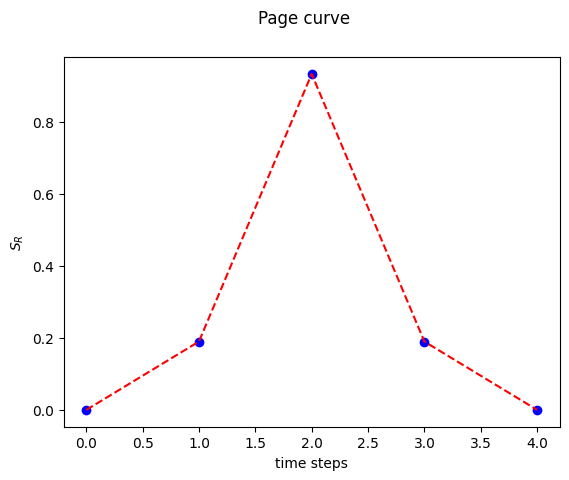

In [7]:
dens1 =bh_evaporation(1)
entropies1 = entropy(1,dens1)
plt.plot(entropies1,"bo", entropies1, "r--")
plt.ylabel('$S_R$')
plt.xlabel("time steps")
plt.suptitle('Page curve')
plt.show()

For $n=2$, we get:

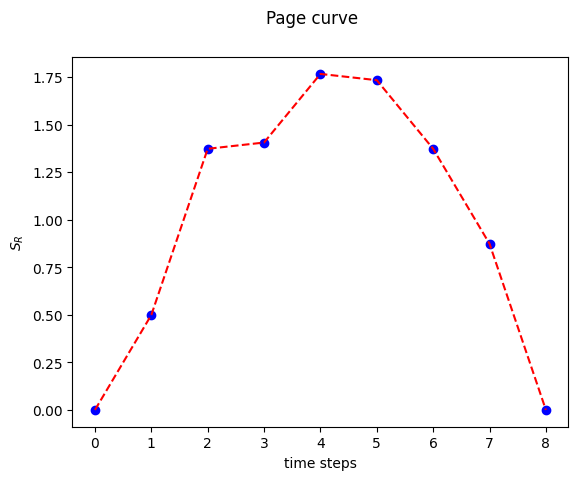

In [8]:
dens2 =bh_evaporation(2)
entropies2 = entropy(2,dens2)
plt.plot(entropies2,"bo", entropies2, "r--")
plt.ylabel('$S_R$')
plt.xlabel("time steps")
plt.suptitle('Page curve')
plt.show()

We can check that the initial incoming matter state is the same as the outgoing hawking radiation state:

In [9]:
print(f"for n=1 the statement is {compare(1,dens1)}")
print(f"for n=2 the statement is {compare(2,dens2)}")

for n=1 the statement is True
for n=2 the statement is True


Finally, let us check the case $n=3$.

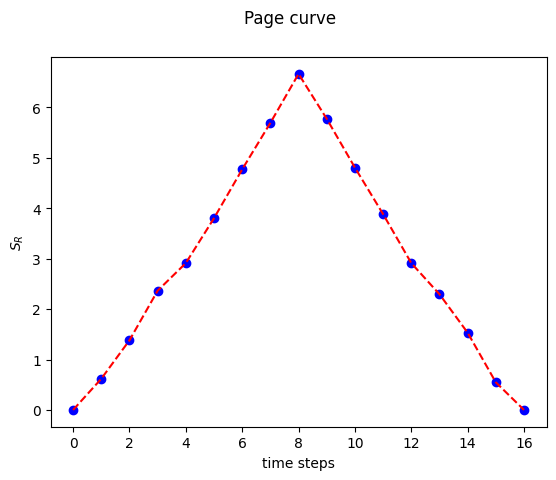

In [10]:
dens3 =bh_evaporation(3)
entropies3 = entropy(3,dens3)
plt.plot(entropies3,"bo", entropies3, "r--")
plt.ylabel('$S_R$')
plt.xlabel("time steps")
plt.suptitle('Page curve')
plt.show()


In [11]:
print(f"for n=3 the statement is {compare(3,dens3)}")

for n=3 the statement is True
